In [47]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision
import warnings
warnings.filterwarnings('ignore')

### Loading Dataset

In [13]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match DenseNet input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])  # Pre-trained model normalization

# Load datasets
train_dataset = datasets.ImageFolder(root='/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/Train', transform=transform)
val_dataset = datasets.ImageFolder(root='/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/Val', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Get class names
class_names = train_dataset.classes
print(f"Classes: {class_names}")

Classes: ['Covid', 'Normal']


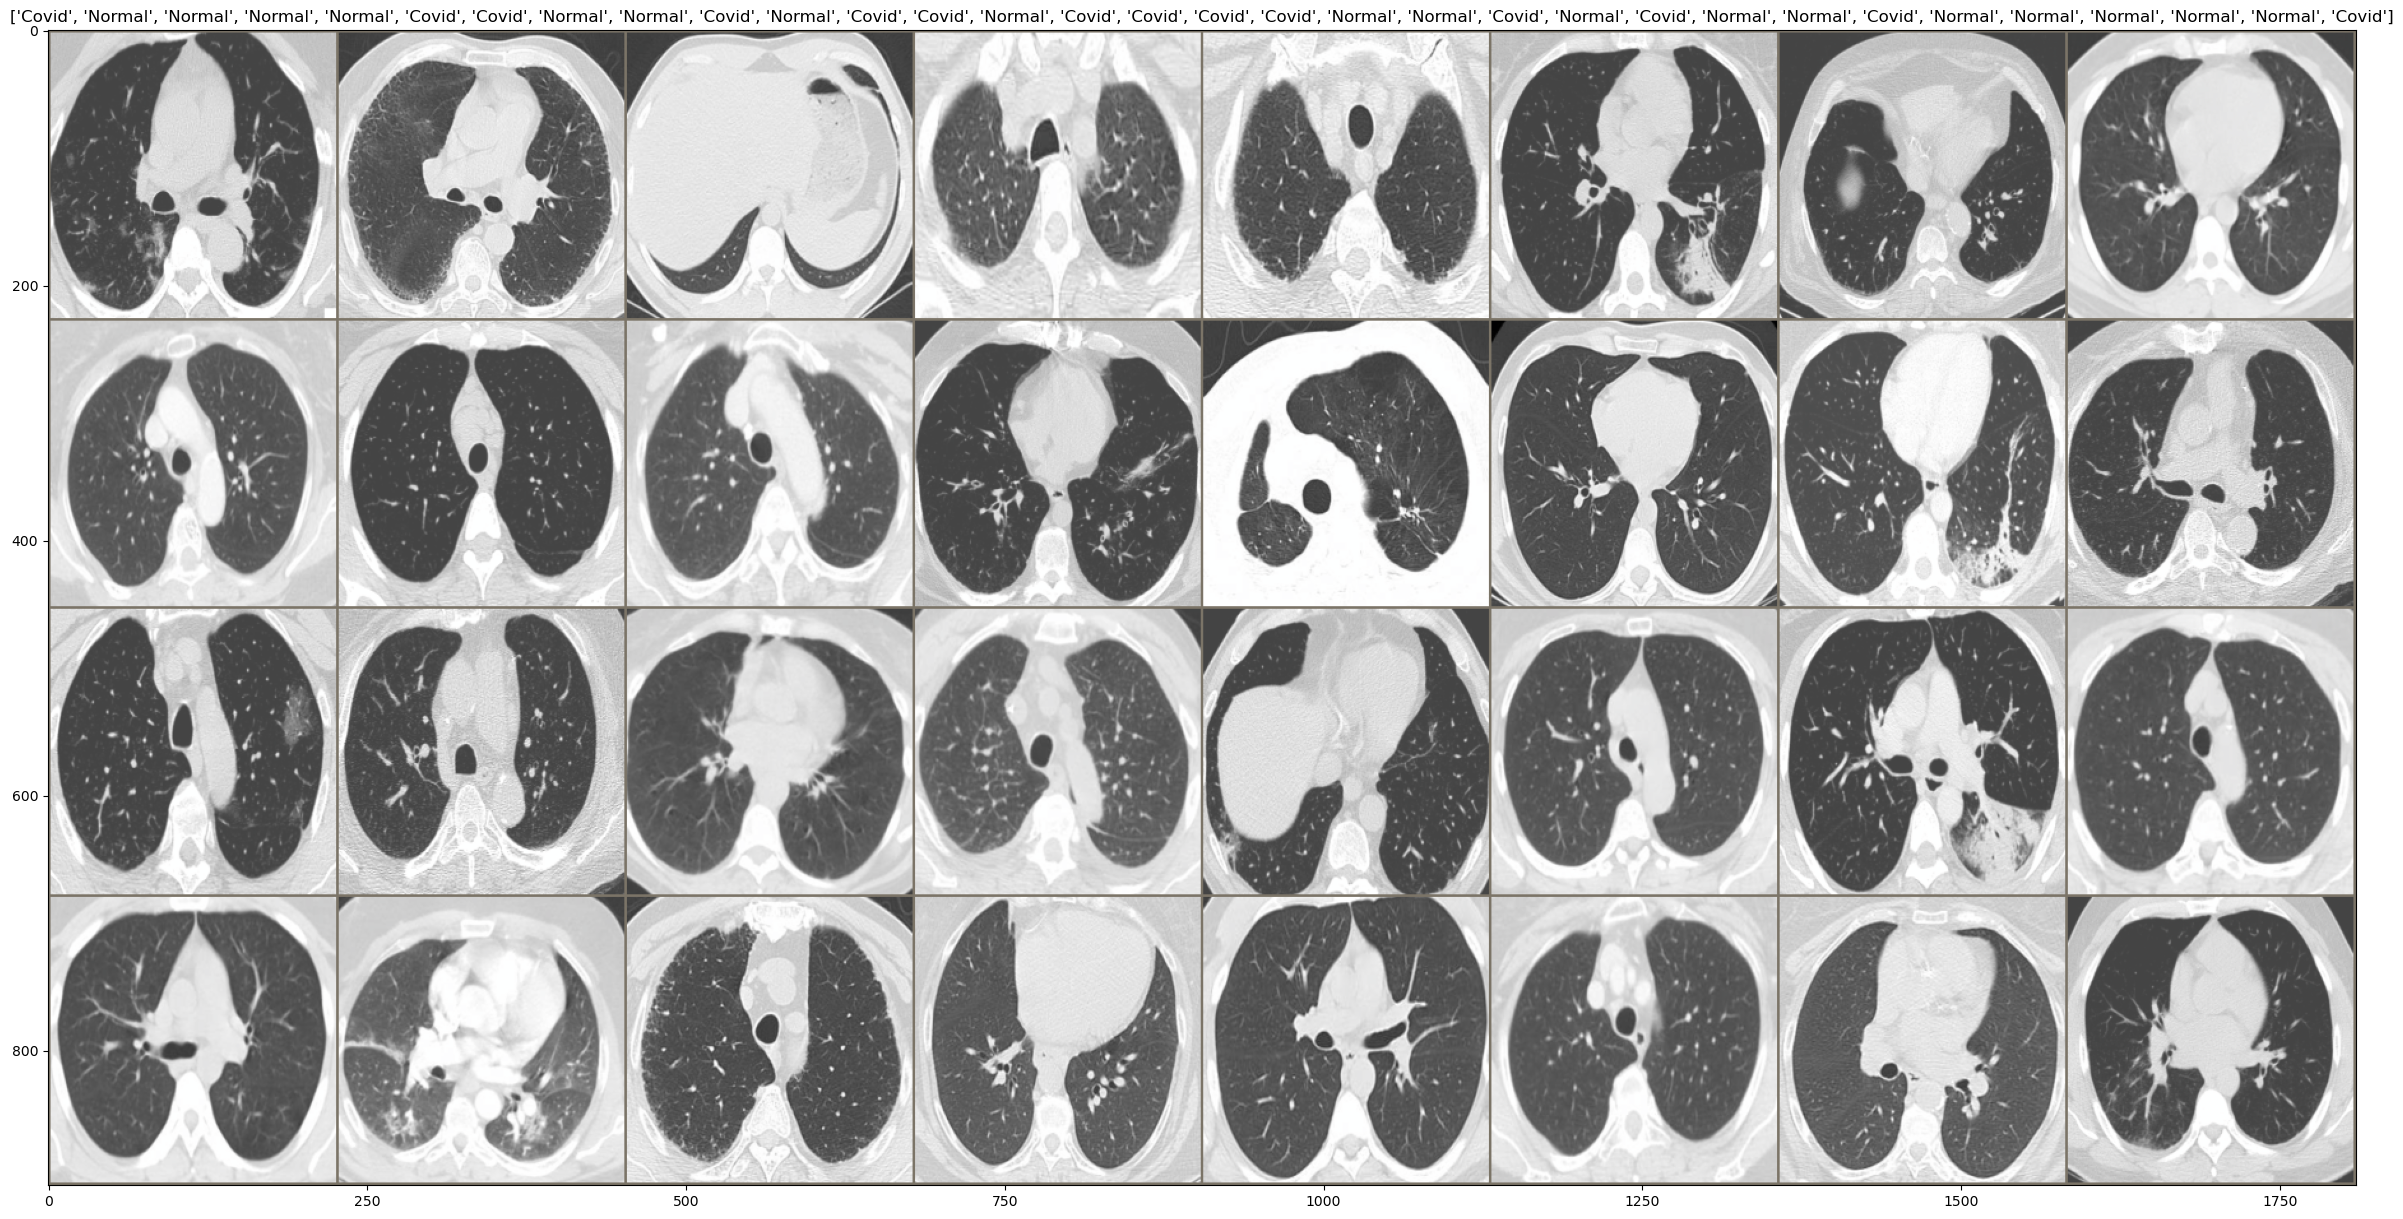

In [43]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(35,15))
# Function to show a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))  # Convert from Tensor to numpy
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean  # Denormalize
    inp = np.clip(inp, 0, 1)  # Clip to valid range
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause to allow update

# Load a batch of data from the train loader
inputs, labels = next(iter(train_loader))

# Display a grid of images with their labels
out = torchvision.utils.make_grid(inputs)
imshow(out, title=[class_names[label] for label in labels])

### Loading Pre-Trained DenseNet

In [49]:
# Load pre-trained DenseNet
model = models.densenet121(pretrained=True)

# Modify the classifier to match the number of classes in your dataset
num_features = model.classifier.in_features
model.classifier = nn.Linear(num_features, len(class_names))

# Move the model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

### Define Loss and Optimizer

In [51]:
criterion = nn.CrossEntropyLoss()  # Loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer

### Model Training

In [53]:
# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()  # Zero gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        
        running_loss += loss.item()
    
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

Epoch 1/10, Loss: 0.12997321433644612
Epoch 2/10, Loss: 0.0803619046727645
Epoch 3/10, Loss: 0.049133011059642864
Epoch 4/10, Loss: 0.025299873050494956
Epoch 5/10, Loss: 0.0066762878940890315
Epoch 6/10, Loss: 0.03986386713297869
Epoch 7/10, Loss: 0.02120358518380993
Epoch 8/10, Loss: 0.0018216942380290832
Epoch 9/10, Loss: 0.029640637699952187
Epoch 10/10, Loss: 0.014409199836242398


### Model Evaluation

In [55]:
model.eval()  # Set model to evaluation mode
correct = 0
total = 0
with torch.no_grad():  # Disable gradient computation
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)  # Get predicted class
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 65.95%


### Saving the Model

In [57]:
torch.save(model.state_dict(), "densenet_model.pth")
print("Model saved as densenet_model.pth")

Model saved as densenet_model.pth


### Load and Predict

In [96]:
# Load the saved model
model.load_state_dict(torch.load("densenet_model.pth"))
model.eval()

# Predict on a single image
from PIL import Image

img_path = "/Users/rohanojha/Documents/01_Sem_1_DS 5220 Code/SML_Project/Code_Test/single_prediction/covid.png"
# img = Image.open(img_path)
img = Image.open(img_path).convert('RGB')
img = transform(img).unsqueeze(0)  # Apply transformations and add batch dimension

# Move to device and predict
img = img.to(device)
output = model(img)
_, predicted_class = torch.max(output, 1)
print(f"Predicted Class: {class_names[predicted_class.item()]}")

Predicted Class: Covid
